In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

c:\Users\Yash\Desktop\LangGraph\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str
    

In [4]:
parent_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')
subgraph_llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [5]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["answer_eng"]}
""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'answer_hin': translated_text}

In [6]:
subgraph_builder = StateGraph(ParentState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

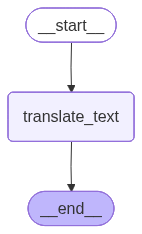

In [7]:
subgraph

In [8]:
def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [9]:
parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", subgraph)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

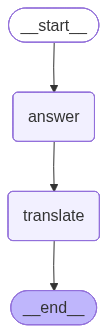

In [11]:
graph = parent_builder.compile()

graph

In [12]:
graph.invoke({'question': 'What is quantum physics'})

{'question': 'What is quantum physics',
 'answer_eng': 'Quantum physics is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. It\'s a realm where our everyday intuition about how the world works breaks down, and instead, we encounter concepts like:\n\n*   **Quantization:** Energy, momentum, and other properties are not continuous but exist in discrete packets called "quanta." Think of it like stairs instead of a ramp – you can only be on certain steps, not in between.\n*   **Wave-Particle Duality:** Particles like electrons and photons can exhibit properties of both waves (like interference and diffraction) and particles (like having a definite position). It\'s as if they can be in multiple places at once until they are observed.\n*   **Superposition:** A quantum system can exist in multiple states simultaneously until a measurement is made. For example, an electron can be spinning both up and down at the same